In [1]:
#file = '/content/drive/MyDrive/CBS/DSBA/project_vivino/NLP/glove.840B.300d.txt'
file = '/content/drive/MyDrive/CBS/DSBA/project_vivino/NLP/glove.6B.100d.txt'

### Load and preprocess

In [4]:
%%capture
! pip install langdetect

In [5]:
from numpy import array
from tensorflow import keras

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('/content/drive/My Drive/CBS/DSBA/project_vivino/Data/finalized_data/all_reviews_and_users.csv', index_col='review_id')
df.head(3)

,Unnamed: 0,Unnamed: 0.1,rating,note,created_at,vintage_id,wine_id,user_id,seo_name,ratings_count,reviews_count,ratings_sum,is_featured,followers_count,followings_count,average_ratings,net_follower_score,types
review_id,,,,,,,,,,,,,,,,,,
65581154,0,0,3.0,"Easy to drink, tastes like a lot of berries mi...",2017-04-01T08:54:16.000Z,22505105,1577018,1404201,valzevul,119,108,424.5,False,9,5,3.567227,1.800000,Red wine
157698730,1,1,4.5,My favorite so far from Pulenta Estate. Cherry...,2020-03-22T00:09:21.000Z,22124179,1153456,3278342,alexis-riv,782,600,3225.0,False,160,257,4.124041,0.622568,Red wine
129034690,2,2,4.5,"Great structure and concentration, with raspbe...",2019-06-07T22:55:23.000Z,22124179,1153456,223051,bernardof,1355,1077,5078.5,False,158,165,3.747970,0.957576,Red wine


In [7]:
df['net_follower_score'] = df['net_follower_score'].replace(np.inf, np.nan)
df = df[['note', 'types', 'rating', 'average_ratings', 'net_follower_score']].dropna(how='any')
df = df.sample(100000, random_state=42)

display(df.head(3))
[print(i,row) for i,row in enumerate(df['note'][:5])]

,note,types,rating,average_ratings,net_follower_score
review_id,,,,,
166771114,"Dark red in color. On nose, raspberry, unripe ...",Red wine,4.0,3.657061,1.250000
87987221,Best vintage for this Larrivet. Plenty of frui...,Red wine,4.5,3.886850,0.600000
118054639,Broke open this one at a birthday celebration ...,Red wine,4.0,3.526807,5.059723


0 Dark red in color. On nose, raspberry, unripe blackberry, vanilla and some bitter chocolate. On pallet, silky tannins, quite fruit driven, found same fruit. Acidity is present, but wine feels quite balanced. Had it with grilled lamb entrecote, grilled aubergine&zuchini, poached beet leaves and some raw cocktail tomatoes. It worked quite nicely together. The mellow after finish of the wine  worked together with the mellow tones of the dish, as the the fruit went well with the vegetables&lamb. 
1 Best vintage for this Larrivet. Plenty of fruits on the nose, same following on the palate. 
Need at least 1-2 hour in the carafe to rest before taste
94 points from me 😜 
2 Broke open this one at a birthday celebration this last weekend and wish I had brought a third bottle.  Highly condensed aromas with eventual hints of plum and espresso.  After it opens up, you get blackberry, cassis, leather, licorice and more of the espresso from the aromas. Good depth with sweet oak added in, mid-palate

[None, None, None, None, None]

In [8]:
from langdetect import detect, detect_langs

df['lang'] = df.apply(lambda row: detect(row['note']), axis=1)

df[df['lang'] != 'en']
df = df[df['lang'] == 'en'] # Only keep english reviews

In [9]:
import spacy
import re
import string
nlp = spacy.load('en')

# Remove punctuation
exclude = set(string.punctuation)
df['note_clean'] = df.apply(lambda row:''.join(ch for ch in row['note'] if ch not in exclude), axis=1)
df.head(2)

,note,types,rating,average_ratings,net_follower_score,lang,note_clean
review_id,,,,,,,
166771114,"Dark red in color. On nose, raspberry, unripe ...",Red wine,4.0,3.657061,1.25,en,Dark red in color On nose raspberry unripe bla...
87987221,Best vintage for this Larrivet. Plenty of frui...,Red wine,4.5,3.886850,0.60,en,Best vintage for this Larrivet Plenty of fruit...


### Bin and onehot encode target values

Wine ratings take on values from 1, 1.5.. 4.5, 5.0, i.e. 9 different classes. Bin it closer together to simplify classification task.
1. **Bad**: 

Bad wines are very underrepresented in the data and is essentially not interesting to predict anyway. Drop it.

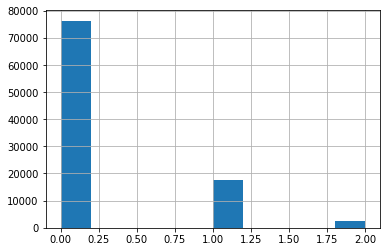

In [10]:
cut_labels = [2,0,1] # Worst wines map to 2, regular to 0 and great to 1
cut_bins = [0, 2.5, 4.0, 5.0]
df['ratings_cut'] = pd.cut(df['rating'], bins=cut_bins, labels=cut_labels)
#df.groupby('ratings_cut').max()

df['ratings_cut'].hist()

In [11]:
df = df[df['ratings_cut'] != 2]

ratings_dist = np.bincount(df['ratings_cut'])
class_weight = {0: (1 / ratings_dist[0]),
                1: (1 / ratings_dist[1] )
                }

## Split into train/test + tokenize

In [12]:
# Tranform to array for faster computing
X = df['note_clean'].to_numpy()
y = df['ratings_cut'].to_numpy()
#y = pd.get_dummies(df['rating']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


vocab_size = len(tokenizer.word_index) + 1

maxlen = 200 # Set maximum sequence length - how long can reveiws be?

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

np.shape(X_train)

(75158, 200)

## Load GLOVE

In [14]:
from numpy import array
from numpy import asarray
from numpy import zeros


embeddings_dictionary = dict()

glove_file = open(file, 'r',encoding="utf8")

# Each line maps as -> word, x1, x2, x3... xn.
# Loop through each line (word) in glove file
for line in glove_file:
    records = line.split() # lines are loaded as strings. Split elements into list
    word = records[0] # First object in list is the word
    vector_dimensions = asarray(records[1:], dtype='float32') # Convert numerical vectors into array
    embeddings_dictionary[word] = vector_dimensions # Maps each word to its numerical vector

glove_file.close()

# Convert embeddings_dict into matrix,
# Where each row, i.e. index value, maps to corresponding numerical vectors
# This is done for faster computation
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Train Unweighted NN

In [29]:
from keras import layers

def create_model(summary=False):
    model = keras.Sequential(
        [ Input(shape=(maxlen,)),
         Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False),
         layers.Dropout(rate=0.2),
         LSTM(128),
         layers.Dropout(rate=0.2),
         Dense(1, activation='sigmoid'),
        ]
    )
   
 #   model = Model(inputs=deep_inputs, outputs=dense_layer_1)

    metrics = ['acc']
    #keras.metrics.Accuracy(name='acc'),
    #keras.metrics.FalseNegatives(name="fn"),
    #keras.metrics.FalsePositives(name="fp"),
    #keras.metrics.TrueNegatives(name="tn"),
    #keras.metrics.TruePositives(name="tp"),
    #keras.metrics.Precision(name="precision"),
    #keras.metrics.Recall(name="recall")
    #]
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

    if summary:
        print(model.summary())

    return model

In [30]:
model = create_model(summary=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          4765200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 4,882,577
Trainable params: 117,377
Non-trainable params: 4,765,200
_________________________________________________________________
None


In [31]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
470/470 [==============================] - 320s 681ms/step - loss: 0.4968 - acc: 0.8091 - val_loss: 0.4765 - val_acc: 0.8167
Epoch 2/5
470/470 [==============================] - 319s 678ms/step - loss: 0.4870 - acc: 0.8103 - val_loss: 0.4765 - val_acc: 0.8167
Epoch 3/5
470/470 [==============================] - 319s 679ms/step - loss: 0.4868 - acc: 0.8103 - val_loss: 0.4766 - val_acc: 0.8167
Epoch 4/5
470/470 [==============================] - 320s 681ms/step - loss: 0.4867 - acc: 0.8103 - val_loss: 0.4765 - val_acc: 0.8167
Epoch 5/5
470/470 [==============================] - 321s 684ms/step - loss: 0.4868 - acc: 0.8103 - val_loss: 0.4765 - val_acc: 0.8167


588/588 [==============================] - 36s 61ms/step - loss: 0.4827 - acc: 0.8124
Test Score: 0.4827246069908142
Test Accuracy: 0.812400221824646


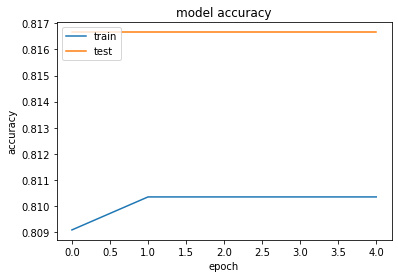

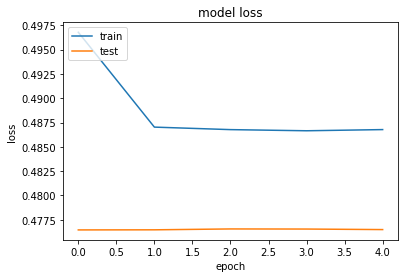

In [32]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

plot_history(history)

In [33]:
history.model.evaluate(X_test, y_test, verbose=1)

588/588 [==============================] - 37s 63ms/step - loss: 0.4827 - acc: 0.8124


[0.4827246069908142, 0.812400221824646]

In [34]:
history.model.save('/content/drive/MyDrive/CBS/DSBA/project_vivino/NLP/NLP_model_no_weights.h5')

## Train weighted NN

In [35]:
model_weight = create_model()

#callbacks = [keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/CBS/DSBA/project_vivino/NLP/NLP_model_weighted_epoch{}.h5')]

In [36]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=5,
                    verbose=1, 
                    validation_split=0.2,
                   class_weight=class_weight
                    )

history.model.save('/content/drive/MyDrive/CBS/DSBA/project_vivino/NLP/NLP_model_weighted.h5')

Epoch 1/5
470/470 [==============================] - 320s 681ms/step - loss: 1.9487e-05 - acc: 0.8103 - val_loss: 0.4778 - val_acc: 0.8167
Epoch 2/5
470/470 [==============================] - 319s 679ms/step - loss: 1.9447e-05 - acc: 0.8103 - val_loss: 0.4779 - val_acc: 0.8167
Epoch 3/5
470/470 [==============================] - 320s 680ms/step - loss: 1.9418e-05 - acc: 0.8103 - val_loss: 0.4781 - val_acc: 0.8167
Epoch 4/5
470/470 [==============================] - 319s 678ms/step - loss: 1.9369e-05 - acc: 0.8103 - val_loss: 0.4783 - val_acc: 0.8167
Epoch 5/5
470/470 [==============================] - 319s 679ms/step - loss: 1.9311e-05 - acc: 0.8103 - val_loss: 0.4785 - val_acc: 0.8167


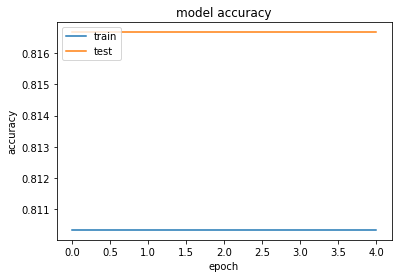

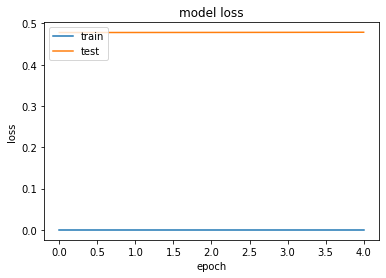

In [37]:
plot_history(history)

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()